# Creating Cloud-Cloudless Paired Dataset

This dataset leverages an existing dataset comprising imagery from five municipalities in Colombia. The structure of the dataset involves each municipality containing 165 images, obtained using the satellite_extractor API and based on SentinelHub, across 12 different channels. Within each municipality, we have identified the optimal cloudless image and stored the corresponding names in a dictionary called `cloudless_groundtruths`. The objective is to subtract this particular cloudless image from the set of 165 images, resulting in 164 images per municipality. Now, each of these 164 images will be paired with the previously identified cloudless image, creating a total of `164 * 2 * NUM_MUNICIPALITIES`, resulting in 1640 images or 820 image pairs in total.

The class `Cloud2CloudlesDataset` replicates each corresponding ground truth for the 164 images in each municipality, storing every pair in a new folder named `DATASET`.

Originally, the images were formatted as `image_DD%%MM%%YY` and will now be renamed to `image_DD%%MM%%YY_gt` for the ground truth image and `image_DD%%MM%%YY_cloud` for the image with clouds.

The class is initialized with the path to the source dataset, containing raw images for each municipality in N folders, and the final path where the new dataset will be stored.

The code includes tests to verify the number of images, ensuring the final count matches the total number of images encountered in the source folder path. Additionally, one of the functions in this class ensures the existence of each folder in the specified path.

In [1]:
import glob
import os
import matplotlib.pyplot as plt
from skimage import io, exposure
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import random
import tifffile
import sys
sys.path.insert(0,'../') 
import satellite_extractor.visualization as viz
import satellite_extractor.utils as utils
from torch.utils.data import Dataset

/Users/sebasmos/opt/anaconda3/envs/sam/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
source_data = "/Users/sebasmos/Downloads/unlabeled-5-top-cities-16-bit-depth"
output_data = "/Users/sebasmos/Downloads/cloud2cloudless_dataset_5_municipalities"
folders = glob.glob(os.path.join(source_data, '*'))
pdf_pages = PdfPages("output.pdf")

In [3]:
cloudless_groundtruths = {
    "Cali": "image_2016-09-04.tiff",
    "Cucuta":"image_2016-10-02.tiff",
    "Medellin":"image_2017-12-17.tiff",
    "Ibague":"image_2017-05-28.tiff",
    "Villavicencio":"image_2017-10-01.tiff"
}

In [19]:
class Cloud2CloudlesDataset(Dataset):
    RESOLUTION = 750

    def __init__(self, source_data: str, output_data: str = None) -> None:
        super().__init__()
        self.source_data = source_data
        self.output_data = output_data
        utils.make_dirs(self.output_data)
        self.folders_all = glob.glob(os.path.join(self.source_data, '*'))
        print(f"{len(self.folders_all)} folders created:\n {self.folders_all}")
    def safe_image_pair(self, output_folder: str, folder: str, index: int, cloudy_image: str, cloudless_image: str) -> None:
        cloudy_image_name, _ = os.path.splitext(os.path.basename(cloudy_image))
        cloudless_image_name, _ = os.path.splitext(os.path.basename(cloudless_image))

        output_cloudy_path = os.path.join(output_folder, f"cloudy_{os.path.basename(folder)}_{index}.tiff")
        output_cloudless_path = os.path.join(output_folder, f"cloudless_{os.path.basename(folder)}_{index}.tiff")

        tifffile.imsave(output_cloudy_path, tifffile.imread(cloudy_image))
        tifffile.imsave(output_cloudless_path, tifffile.imread(cloudless_image))

        print(f"Pair saved: {output_cloudy_path}, {output_cloudless_path}")


    def safe_image_pair_by_date(self, output_folder: str, folder: str, cloudy_image: str, cloudless_image: str) -> None:
        cloudy_image_name, _ = os.path.splitext(os.path.basename(cloudy_image))
        cloudless_image_name, _ = os.path.splitext(os.path.basename(cloudless_image))

        output_cloudy_path = os.path.join(output_folder, f"cloudy_{os.path.basename(folder)}_{cloudy_image_name}")
        output_cloudless_path = os.path.join(output_folder, f"cloudless_{os.path.basename(folder)}_{cloudless_image_name}")

        tifffile.imsave(output_cloudy_path, tifffile.imread(cloudy_image))
        tifffile.imsave(output_cloudless_path, tifffile.imread(cloudless_image))

        print(f"Pair saved: {output_cloudy_path}, {output_cloudless_path}")

    @staticmethod
    def get_RESOLUTION():
        return Cloud2CloudlesDataset.RESOLUTION

    @staticmethod
    def check_image_sizes(path: str, path_final: str) -> None:
        print(path, len(glob.glob(os.path.join(path, '*'))))
        print(path_final, len(glob.glob(os.path.join(path_final, '*'))))
    def create_dataset(self):
        for i, folder in enumerate(self.folders_all):
            cloudy_images = glob.glob(os.path.join(folder, '*.tiff'))
            city_name = os.path.basename(folder)

            if city_name in cloudless_groundtruths:
                cloudless_image_name = cloudless_groundtruths[city_name]
                cloudless_image = os.path.join(folder, cloudless_image_name)

                # Check if the cloudy image has the same name as the cloudless image
                for index, cloudy_image in enumerate(cloudy_images):
                    if os.path.basename(cloudy_image) == cloudless_image_name:
                        # Skip the pair if the names match
                        continue

                    # Save the pair for each city
                    self.safe_image_pair(self.output_data, folder, index + 1, cloudy_image, cloudless_image)

        print("Finished")

dataset = Cloud2CloudlesDataset(source_data, output_data)
dataset.create_dataset()



5 folders created:
 ['/Users/sebasmos/Downloads/unlabeled-5-top-cities-16-bit-depth/Cali', '/Users/sebasmos/Downloads/unlabeled-5-top-cities-16-bit-depth/Medellin', '/Users/sebasmos/Downloads/unlabeled-5-top-cities-16-bit-depth/Cucuta', '/Users/sebasmos/Downloads/unlabeled-5-top-cities-16-bit-depth/Villavicencio', '/Users/sebasmos/Downloads/unlabeled-5-top-cities-16-bit-depth/Ibague']
Pair saved: /Users/sebasmos/Downloads/cloud2cloudless_dataset_5_municipalities/cloudy_Cali_1.tiff, /Users/sebasmos/Downloads/cloud2cloudless_dataset_5_municipalities/cloudless_Cali_1.tiff
Pair saved: /Users/sebasmos/Downloads/cloud2cloudless_dataset_5_municipalities/cloudy_Cali_2.tiff, /Users/sebasmos/Downloads/cloud2cloudless_dataset_5_municipalities/cloudless_Cali_2.tiff


/var/folders/cs/k6_04mpn0h70n9397cr_wz3r0000gn/T/ipykernel_30796/1120508720.py:18: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave(output_cloudy_path, tifffile.imread(cloudy_image))
/var/folders/cs/k6_04mpn0h70n9397cr_wz3r0000gn/T/ipykernel_30796/1120508720.py:19: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave(output_cloudless_path, tifffile.imread(cloudless_image))


Pair saved: /Users/sebasmos/Downloads/cloud2cloudless_dataset_5_municipalities/cloudy_Cali_3.tiff, /Users/sebasmos/Downloads/cloud2cloudless_dataset_5_municipalities/cloudless_Cali_3.tiff
Pair saved: /Users/sebasmos/Downloads/cloud2cloudless_dataset_5_municipalities/cloudy_Cali_4.tiff, /Users/sebasmos/Downloads/cloud2cloudless_dataset_5_municipalities/cloudless_Cali_4.tiff
Pair saved: /Users/sebasmos/Downloads/cloud2cloudless_dataset_5_municipalities/cloudy_Cali_5.tiff, /Users/sebasmos/Downloads/cloud2cloudless_dataset_5_municipalities/cloudless_Cali_5.tiff
Pair saved: /Users/sebasmos/Downloads/cloud2cloudless_dataset_5_municipalities/cloudy_Cali_6.tiff, /Users/sebasmos/Downloads/cloud2cloudless_dataset_5_municipalities/cloudless_Cali_6.tiff
Pair saved: /Users/sebasmos/Downloads/cloud2cloudless_dataset_5_municipalities/cloudy_Cali_7.tiff, /Users/sebasmos/Downloads/cloud2cloudless_dataset_5_municipalities/cloudless_Cali_7.tiff
Pair saved: /Users/sebasmos/Downloads/cloud2cloudless_datase

(origin shape: cloudless_Ibague_28.tiff: (746, 746, 12) -> rescale: (746, 746, 12)) - Range -> [(0.0, 1.0)]
(origin shape: cloudy_Ibague_28.tiff: (746, 746, 12) -> rescale: (746, 746, 12)) - Range -> [(0.0, 1.0)]
(origin shape: cloudless_Cucuta_9.tiff: (751, 742, 12) -> rescale: (751, 742, 12)) - Range -> [(0.0, 1.0)]
(origin shape: cloudy_Cucuta_9.tiff: (751, 742, 12) -> rescale: (751, 742, 12)) - Range -> [(0.0, 1.0)]
(origin shape: cloudless_Villavicencio_24.tiff: (747, 745, 12) -> rescale: (747, 745, 12)) - Range -> [(0.0, 1.0)]
(origin shape: cloudy_Villavicencio_24.tiff: (747, 745, 12) -> rescale: (747, 745, 12)) - Range -> [(0.0, 1.0)]
(origin shape: cloudless_Medellin_52.tiff: (745, 747, 12) -> rescale: (745, 747, 12)) - Range -> [(0.0, 1.0)]
(origin shape: cloudy_Medellin_52.tiff: (745, 747, 12) -> rescale: (745, 747, 12)) - Range -> [(0.0, 1.0)]
(origin shape: cloudless_Villavicencio_49.tiff: (747, 745, 12) -> rescale: (747, 745, 12)) - Range -> [(0.0, 1.0)]
(origin shape: cl

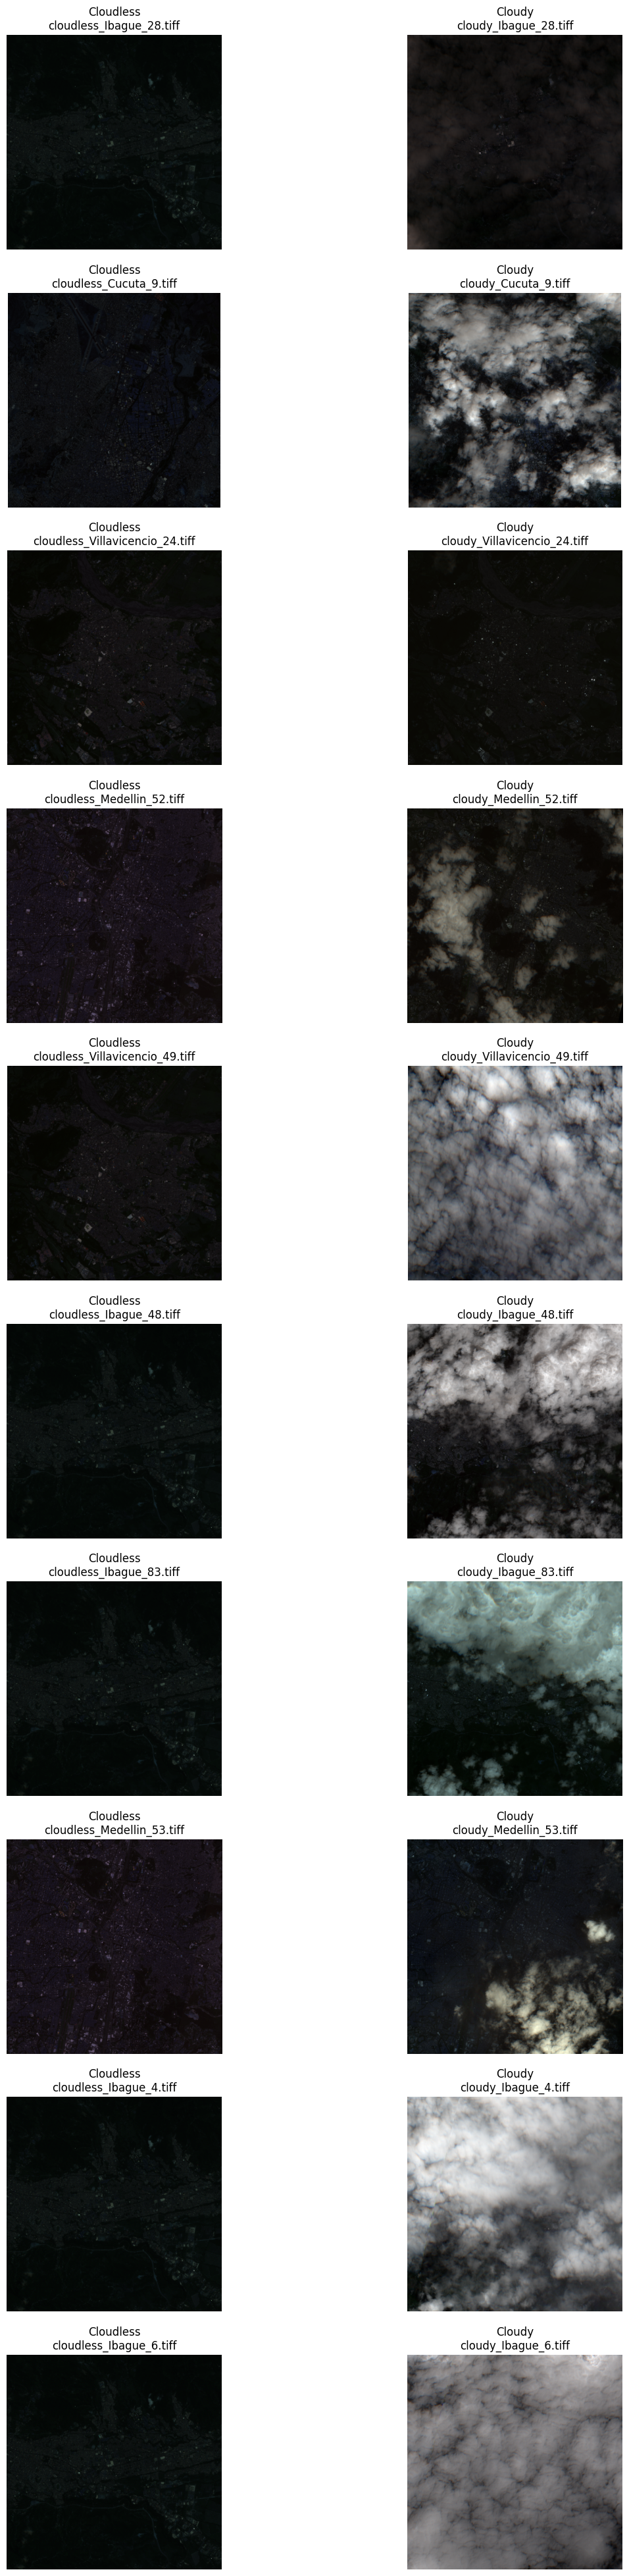

Processed images in '/Users/sebasmos/Downloads/cloud2cloudless_dataset_5_municipalities' with 515 images.


In [4]:
viz.plot_image_pairs_to_pdf(output_data)
